# Initialization

In [110]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from matplotlib import gridspec


In [4]:
train_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

train=pd.read_csv(train_url, compression='gzip')

In [5]:
train.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
train.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
19361,None,273.22,0.00,0.0,5,Clear,sky is clear,2015-11-07 08:00:00,3047
16466,None,299.10,0.00,0.0,75,Clouds,broken clouds,2015-07-11 13:00:00,4483
1003,None,276.29,0.00,0.0,90,Clouds,overcast clouds,2012-11-08 05:00:00,2681
25680,None,298.15,0.00,0.0,48,Clouds,scattered clouds,2016-08-12 14:00:00,4773
47108,None,296.89,1.78,0.0,40,Rain,moderate rain,2018-08-26 23:00:00,1208


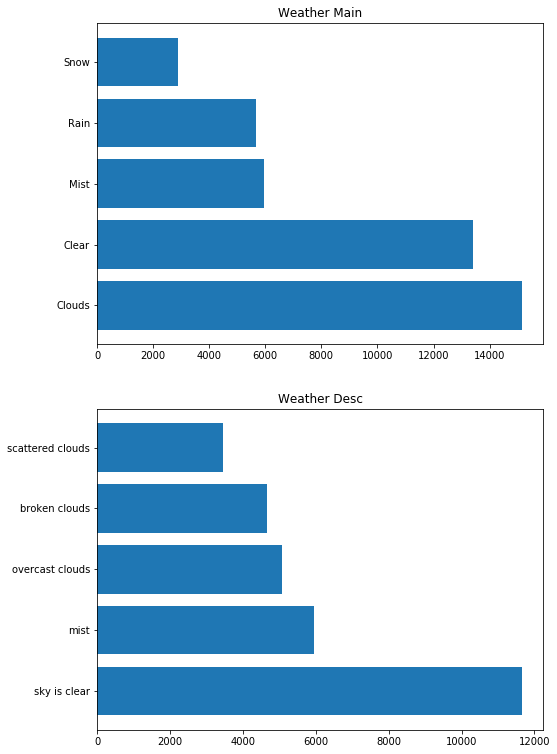

In [60]:
plt.figure(figsize=(8, 13))
plt.subplot(211)
df=train.weather_main.value_counts().head(5)
plt.barh(df.index, df)
plt.title('Weather Main')
df=train.weather_description.value_counts().head(5)
plt.subplot(212)
plt.barh(df.index, df)
plt.title('Weather Desc')
#plt.subplots_adjust(hspace=0.5)
plt.show()


[None, None]

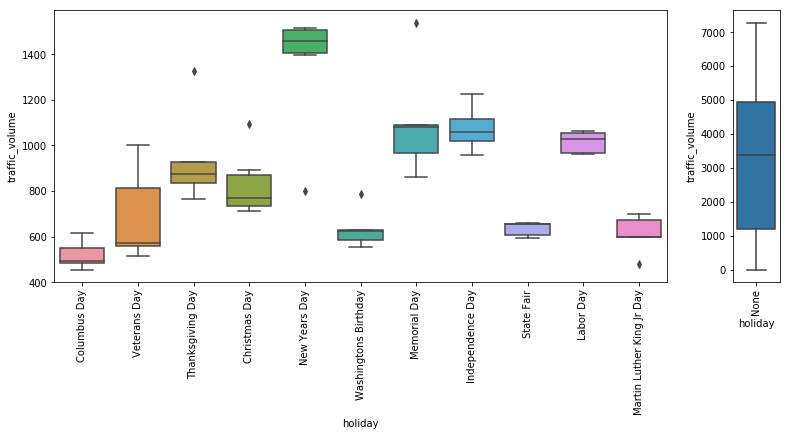

In [177]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(13,5))
# set up subplot grid
#gridspec.GridSpec(15, 12)

rows=1
columns=13 # 11 holidays + 1 no holiday (None) + 1 for labels
# large subplot
plt.subplot2grid((rows,columns), (0,0), colspan=11, rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] != "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)

# small subplot 1
plt.subplot2grid((rows,columns), (0, columns-1), rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] == "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)